In [1]:
from fastai.imports import *
import fastai

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
import IPython

from sklearn import metrics
import os


In [96]:
PATH = "Bulldoze Data/"
df_raw = pd.read_csv(f'{PATH}Train.csv', parse_dates=["saledate"], low_memory=False)
df_raw.SalePrice = np.log(df_raw.SalePrice)

# Data Processing

In [97]:
# Cleaning Data
import pandas.api.types as ptypes

for n, c in df_raw.items():
    if ptypes.is_string_dtype(c): df_raw[n] = c.astype('category').cat.as_ordered()

df_raw.UsageBand.cat.set_categories(['High', 'Medium', 'Low'], ordered = True, inplace=True)
df_raw.isnull().sum().sort_index()/len(df_raw)

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

In [98]:
# Transforming datetime column
prefix = 'sale'
attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear', 'Is_month_end', 'Is_month_start', 
            'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
df_raw.saledate = pd.to_datetime(df_raw.saledate, infer_datetime_format=True)
#df_raw.sort_values(by='saledate', inplace=True)
#df_raw.reset_index(inplace=True)
for i in attr:
    df_raw[prefix+i] = getattr(df_raw.saledate.dt, i.lower())
df_raw[prefix+'Elapsed'] = pd.to_datetime(df_raw.saledate, infer_datetime_format=True).astype(np.int64)
df_raw.drop('saledate', axis = 1, inplace = True)

In [99]:
# to save fast
os.makedirs('tmp', exist_ok = True)
df_raw.to_feather('tmp/raw')

In [100]:
# to read fast
df_raw = pd.read_feather('tmp/raw')

In [270]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)
display_all(df_raw.isnull().sum().sort_index()/len(df_raw))

Backhoe_Mounting            0.803872
Blade_Extension             0.937129
Blade_Type                  0.800977
Blade_Width                 0.937129
Coupler                     0.466620
Coupler_System              0.891660
Differential_Type           0.826959
Drive_System                0.739829
Enclosure                   0.000810
Enclosure_Type              0.937129
Engine_Horsepower           0.937129
Forks                       0.521154
Grouser_Tracks              0.891899
Grouser_Type                0.752813
Hydraulics                  0.200823
Hydraulics_Flow             0.891899
MachineHoursCurrentMeter    0.644089
MachineID                   0.000000
ModelID                     0.000000
Pad_Type                    0.802720
Pattern_Changer             0.752651
ProductGroup                0.000000
ProductGroupDesc            0.000000
ProductSize                 0.525460
Pushblock                   0.937129
Ride_Control                0.629527
Ripper                      0.740388
S

## Major processing 
Replace strings with numeric codes, handle missing values, and split the dependent variable into a separate variable

In [233]:
df_bull = df_raw.copy()

# Splitting dependent variable
#y = df.SalePrice
#df.drop('SalePrice', axis = 1, inplace = True)

# Fixing continuous missing values and numeric codes (-1 to 0)
import pandas.api.types as ptypes
for n,c in df_bull.items():
    if ptypes.is_numeric_dtype(c):
        if pd.isnull(c).sum(): 
            df_bull[n+'_na'] = pd.isnull(c)
            df_bull[n] = c.fillna(c.median())
    if not ptypes.is_numeric_dtype(c):
        df_bull[n] = c.cat.codes+1

In [263]:
rf_full = RandomForestRegressor(n_jobs = -1)
y = df_bull.SalePrice
rf_full.fit(df_bull.drop('SalePrice', axis = 1), y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [234]:
df_bull.shape

(401125, 67)

Even though the R^2 score is high, we may have an issue with overfitting. Additionally, it takes a long time to complete training for the above formula, so we are going to train on the subset of data for tuning.

# Validation Sets
Validation sets ensure that the model generalizes well beyond training sets. We are trying to predict prices in the future, so we are going to write up a validation split function that trains on past data and validates on the latest from train.csv

In [235]:
def split_vals(a, n): return a[:n].copy(), a[n:].copy()

n_valid = 12000 # same as Kaggle's test set size
n_trn = len(df_bull) - n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train_big, X_valid = split_vals(df_bull, n_trn)
y_train_big, y_valid = X_train_big.SalePrice, X_valid.SalePrice

y_train_big = np.array(y_train_big)
y_valid = np.array(y_valid)

X_train_big.drop('SalePrice', axis = 1, inplace = True)
X_valid.drop('SalePrice', axis = 1, inplace = True)

X_train_big.shape, y_train_big.shape, X_valid.shape, y_valid.shape

((389125, 66), (389125,), (12000, 66), (12000,))

In [236]:
import math
def rmse(predicted, true_vals): return math.sqrt(((predicted-true_vals)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [115]:
m = RandomForestRegressor(n_jobs = -1)
m.fit(X_train_big, y_train_big)
print_score(m)

[0.07338151339241195, 0.234597809890476, 0.9882751848449969, 0.9017130449392424]


This is really high! We get 90% accuracy for the validation set with all the default parameters of the RF model. Now, we would want to tune the model up to get it even more accurate, but first we need to speed things up.

## Speeding training up
We are going to subset train dataframe to speed up training of complex models faster and find optimal parameters

In [256]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

df_trn = get_sample(df_bull, n=30000)
y_trn = df_trn.SalePrice

X_train, _ = split_vals(df_trn, 20000)
y_train = X_train.SalePrice

X_train.drop('SalePrice', axis = 1, inplace = True)
X_train.shape

(20000, 66)

In [265]:
rf = RandomForestRegressor(n_jobs = -1)
rf.fit(X_train, y_train)
print_score(rf)

[0.09205885899655694, 0.35401280275898084, 0.9816010960670577, 0.7761866896194721]


Before we jump into hyperparameter tuning, let's visualize single decision tree to better understand what is happening in the random forest

# Single Tree
Let's first focus on a single tree and tune random forest from there. Best splits are combinations of variables and splits such that the resulting dependent variable groups are as different from each other as possible. For each variable for each possible value of that variable we see whether the split is better than the other variables' splits based on the weighted average of the RMSE.

In [238]:
rf_1 = RandomForestRegressor(n_estimators = 1, max_depth = 3, bootstrap = False, n_jobs = -1)
rf_1.fit(X_train, y_train)
print_score(rf_1)

[0.5167844627684836, 0.5818496564607561, 0.41378807762988956, 0.39539805709497056]


In [ ]:
# Load libraries

from IPython.display import Image  
from sklearn import tree
import pydotplus

# Create DOT data
dot_data = tree.export_graphviz(rf.estimators_[0], out_file=None, 
                                feature_names=X_train.columns)

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [250]:
rf_1d = RandomForestRegressor(n_estimators = 1, bootstrap = False, n_jobs = -1)
rf_1d.fit(X_train, y_train)
print_score(rf_1d)

[6.879800455918813e-17, 0.5086849896629092, 1.0, 0.5378895185121731]


# Random Forests
Random Forests is a way of bagging regular decision trees! So, let us first understand bagging.

## Bagging
You can bag any kind of model. Bagging - what if we created 5 different model, which are weak individually, but the models weren't predicted with each other - 5 models would have found different insights, so if you took the average - you are brining insights from each model. That is an example of an ensemble. Each has random UNCORRELATED errors - and when we average we get error of 0! Picks out rows to train each model on with replacement - so could be double. Impotant to create uncorrelted trees than accuracte trees for RF

In [275]:
np.random.seed(1234)
m = RandomForestRegressor(n_jobs=-1, n_estimators = 100)
%time m.fit(X_train, y_train)
print_score(m)

CPU times: user 36.7 s, sys: 264 ms, total: 37 s
Wall time: 10.2 s
[0.09345387548582301, 0.35373067077453696, 0.9810642030154719, 0.7765432853759939]


In [276]:
preds = np.stack([t.predict(X_valid) for t in m.estimators_])
(preds[:,0], np.mean(preds[:,0]), list(y_valid)[0])

(array([9.85219426, 9.25913054, 8.98719682, 9.85219426, 9.21034037,
        9.680344  , 9.10497986, 9.04782144, 9.15904708, 9.82552601,
        9.18502256, 9.82552601, 9.10497986, 9.25913054, 8.98719682,
        8.98719682, 9.85219426, 8.98719682, 9.85219426, 9.39266193,
        9.21034037, 9.82552601, 9.58190393, 9.25913054, 9.39266193,
        9.15904708, 8.9226583 , 8.98719682, 9.15904708, 9.04782144,
        9.21034037, 9.10497986, 9.21034037, 9.35010231, 9.39266193,
        9.04782144, 8.9226583 , 9.39266193, 9.54681261, 9.25913054,
        9.54681261, 9.85219426, 8.98719682, 9.85219426, 9.30565055,
        8.98719682, 9.85219426, 9.85219426, 9.30565055, 9.85219426,
        9.04782144, 9.85219426, 8.98719682, 9.82552601, 9.15904708,
        9.18502256, 9.85219426, 9.30565055, 9.85219426, 9.82552601,
        9.85219426, 9.85219426, 9.85219426, 9.82552601, 8.98719682,
        9.10497986, 9.82552601, 9.82552601, 9.85219426, 9.25913054,
        9.85219426, 9.85219426, 9.35010231, 9.10

We can see that individually decision trees are doing an OK job at predicting individual data points from the validation set. However, when we average out predictions of all decision trees we get a relatively close result.

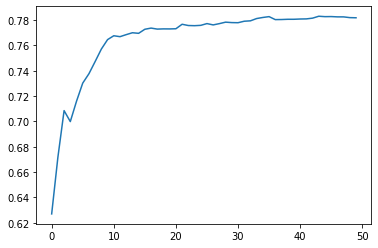

In [277]:
plt.plot([metrics.r2_score(y_valid, np.mean(preds[:i+1], axis=0)) for i in range(50)]);

The shape of this curve suggests that adding more trees isn't going to help us much. Let's check. (Compare this to our original model on a sample)

In [244]:
m = RandomForestRegressor(n_estimators=20, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.10305868321180377, 0.3576565728122834, 0.9766866368280356, 0.7715556636760061]


In [245]:
m = RandomForestRegressor(n_estimators=30, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.0997376738742977, 0.3557822906705682, 0.97816494846915, 0.7739436932690522]


In [246]:
m = RandomForestRegressor(n_estimators=50, n_jobs=-1)
m.fit(X_train, y_train)
print_score(m)

[0.09620826175315605, 0.3500824254635219, 0.9796829575980793, 0.7811288133866605]


From the above it we can clearly see that going above n_estimators of 30 has a small marginal effect on the validation score.

### Uncorrelated Trees
If you build 1000 trees on 10 datapoints than the predictions are going to be very different -> correlations between predictions will be small (individual trees are not generalizing very well). On the other hand, if we build 1000 trees on almost all data we will get highly correlated trees and predictions (no generalize very well).

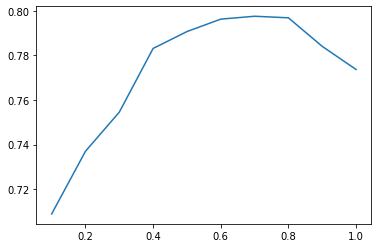

In [267]:
preds = []
for i in range(1,11):
    m = RandomForestRegressor(n_jobs=-1, max_features = i/10)
    m.fit(X_train, y_train)
    preds.append(m.predict(X_valid))

plt.plot(np.array([*range(1,11)])/10,[metrics.r2_score(y_valid, preds[i]) for i in range(10)]);

## Out-of-bag (OOB) score
Is our validation set worse than our training set because we're over-fitting, or because the validation set is for a different time period, or a bit of both? With the existing information we've shown, we can't tell. However, random forests have a very clever trick called out-of-bag (OOB) error which can handle this (and more!)

The idea is to calculate error on the training set, but only include the trees in the calculation of a row's error where that row was not included in training that tree. This allows us to see whether the model is over-fitting, without needing a separate validation set.

This also has the benefit of allowing us to see whether our model generalizes, even if we only have a small amount of data so want to avoid separating some out to create a validation set.

This is as simple as adding one more parameter to our model constructor.

In [271]:
m = RandomForestRegressor(n_estimators=40, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.09544354462005594, 0.35040071905254877, 0.9802232967908303, 0.7807306387845608, 0.8574614866733806]


## Best Practice
Do most of the models on subsets of data! Speed at the beginning is key

In [380]:
def get_sample(df,n):
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

n_valid = 12000
n_trn = len(df_bull)-n_valid

X_train, X_valid = split_vals(df_bull.drop('SalePrice', axis = 1), n_trn)
y_train, y_valid = split_vals(y, n_trn)
raw_train, raw_valid = split_vals(df_bull, n_trn)
X_train.shape

(389125, 66)

### Ovoiding Overfitting
1. Subsampling (above)
2. Reduce the tree depth - min_samples_leaf = 3, not one
3. Reduce number of features available for each tree. For example, max_features = 0.5 - less correlation the better - what if every tree uses one very imortant column, but we might imagine there are some interactions that are important. So, in addition, to choosing subset of rows, at every split point we choose a different SUBSET of columns. Every possible level of a random subset of columns!
Trees are differnet on rows, max_features - indicates to use different columns

def set_rf_samples(n):
    """ Changes Scikit learn's random forests to give each tree a random sample of
    n random rows.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples():
    """ Undoes the changes produced by set_rf_samples.
    """
    forest._generate_sample_indices = (lambda rs, n_samples:
        forest.check_random_state(rs).randint(0, n_samples, n_samples))

### Summary of RF hyperparameters effects

set_rf_samples - rows in each tree, if rf_samples = 20000, then if tree is balanced, # of layers is log_2(20000), # of leaf nodes - 20000. decrease sample size - less final decisions - tree is less rich, less binary choices. Low - less overfitting, less accuract individual tree models. When building a bagging model - try to achive 2 things: each individual model is as accuracte as possible + across estimators - the correlation is as low as possible. So when we decrease the rf sample we decrease the power of the esimator but achive the 2nd thing: keeping the correlation low.

min_samples_leaf - if set it to 2 then # of layers is log_2(20000) - 2, each time we double min_samples_leaf we subtract one layer. Leaf nodes: 10k. Each leaf has more than one thing in it = more stable average. Less depth. Result - each esimator - less predictive, but also predictors will be less correlated. 
- 1, 3, 5, 10, 25, 100

max_features - at each split it will randomly pick differnt proportion of the features. We want the trees to be as rich as possible. Picking different subset of features at each decision point.
- None
- 0.5
- 'sqrt'



In [377]:
from sklearn.ensemble import forest

def set_rf_samples(n): 
    """ Changes Scikit learn's random forests to give each tree a random sample of n random rows. """ 
    forest._generate_sample_indices = (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples, n))

def reset_rf_samples(): 
    """ Undoes the changes produced by set_rf_samples. """ 
    forest._generate_sample_indices = (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples, n_samples))

/Users/nyatchen/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


# Confidence based on tree variance
Let's continue using a subset of data and examine variability in predictions made by random forests.

In [381]:
set_rf_samples(50000)

m_rf = RandomForestRegressor(n_estimators = 70, min_samples_leaf = 3, max_features = 0.7, n_jobs = -1, oob_score = True)
m_rf.fit(X_train, y_train)
print_score(m_rf)

[0.1147321319669377, 0.22664593381562867, 0.9724890901577706, 0.9082631469794772, 0.9143130919519498]


How do we know how confident we are in the predictions made by the model above? We know we get them by averaging predictions made by single decision trees in a forest. One simple way os to use the standard deviation of predictions, instead of the mean. This tells us the relative confidence of predictions - that is, how much variability there is amongst prediction for specific row. Higher variability means less certainty in the prediction. Let's obtain standard deviation of the preditions:

In [382]:
preds = np.stack([t.predict(X_valid) for t in m_rf.estimators_])
(np.mean(preds[:, 0]), np.std(preds[:, 0]))

(9.185478288922003, 0.18298697020614066)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

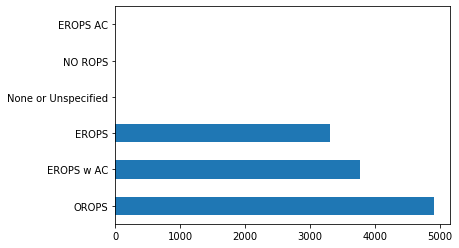

In [383]:
raw_train, raw_valid = split_vals(df_raw, n_trn)

x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [384]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,9.849178,9.839937,0.240963
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,10.623971,10.591811,0.228173
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,9.682064,9.680337,0.199959


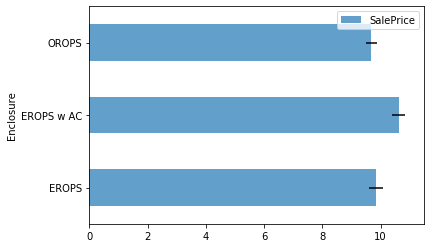

In [385]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', alpha = 0.7, xlim = (0,11.5), xerr = 'pred_std');

From the dataframe above we can clearly tell that the predictions are close, but the standard deviation is high - why is that ?

Let's investigate our train dataset and compare its ProductSize distribution to the validation set

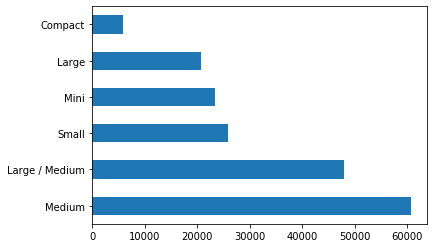

In [386]:
temp = X_train.ProductSize.astype('category').map(dict( zip( raw_valid.ProductSize.cat.codes + 1, raw_valid.ProductSize ) ))
temp.value_counts().plot.barh();

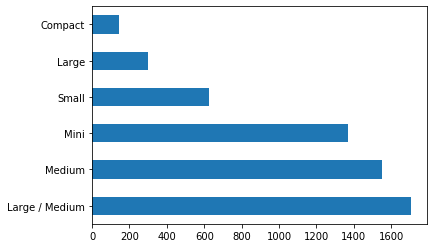

In [387]:
raw_valid.ProductSize.value_counts().plot.barh();

In [388]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,9.735093,9.808980,0.280412
Large,10.470589,10.418249,0.321988
Large / Medium,10.691871,10.662690,0.265536
Medium,10.681511,10.628503,0.243639
Mini,9.535147,9.552454,0.208751
Small,10.324448,10.346072,0.265052


Comparing the 3 graphics above it makes sense that Large and Compact categories have the largest unceratinty. In the trianing set these categories are underrepresented vs what we see in the validation set.

# Feature Importance
It's not just enough to know that a model can make accurate predictions - we also would like to know how it is making those predictions. The most straightforward way to see this is whith feature importance

In [389]:
feat_imp = pd.DataFrame({'cols':X_train.columns, 'imp':m_rf.feature_importances_}
                       ).sort_values('imp', ascending=False)
feat_imp.head(15)

,cols,imp
5,YearMade,0.176295
37,Coupler_System,0.155812
13,ProductSize,0.104854
14,fiProductClassDesc,0.093501
2,ModelID,0.067426
63,saleElapsed,0.061963
10,fiSecondaryDesc,0.041297
8,fiModelDesc,0.031474
38,Grouser_Tracks,0.029147
19,Enclosure,0.029016


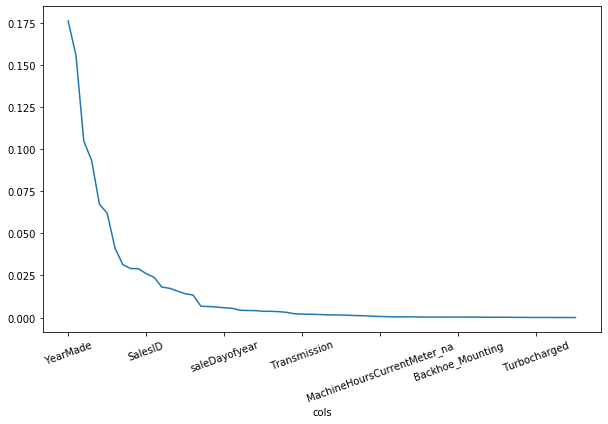

In [390]:
feat_imp.plot('cols', 'imp', figsize=(10,6), legend = False);
plt.xticks(rotation=20);

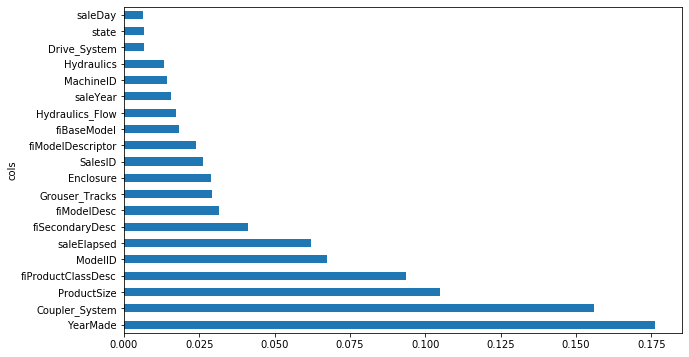

In [391]:
feat_imp.iloc[:20,:].plot('cols', 'imp', 'barh', legend = False, figsize = (10,6));

In [392]:
to_keep = feat_imp[feat_imp.imp>0.005].cols; len(to_keep)

22

In [393]:
df_keep = df_bull[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [394]:
m_rf = RandomForestRegressor(n_estimators = 70, min_samples_leaf = 3, max_features = 0.7, n_jobs = -1, oob_score = True)
m_rf.fit(X_train, y_train)
print_score(m_rf)

[0.11938628373449263, 0.22370025038128546, 0.9702118389359882, 0.9106322313833296, 0.9120755641994006]


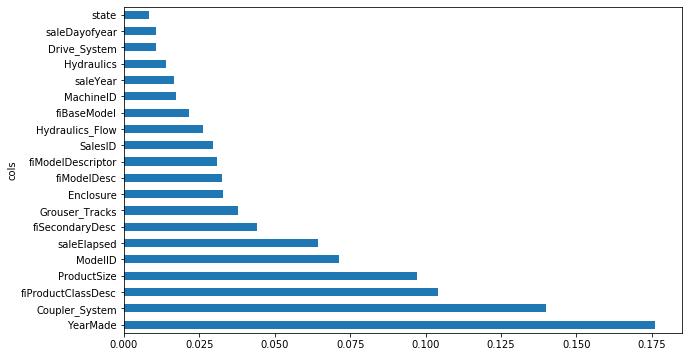

In [395]:
feat_imp_new = pd.DataFrame({'cols':X_train.columns, 'imp':m_rf.feature_importances_}
                       ).sort_values('imp', ascending=False)
feat_imp_new.iloc[:20,:].plot('cols', 'imp', 'barh', legend = False, figsize = (10,6));